In [128]:
import sys
sys.path.append('..')

import importlib
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from datetime import datetime, timedelta
from enum import Enum
from typing import NamedTuple

import mim.extractors.skane_1718 as skane1718

In [38]:
from datetime import datetime

def parse_iso8601_datetime(s) -> datetime:
    return datetime.strptime(s, "%Y-%m-%d %H:%M:%S")

In [3]:
DATA_ROOT = "/mnt/air-crypt/air-crypt-raw/andersb/data/Skane_17-18/Uttag_1"

FILES = {fname: DATA_ROOT + "/" + fname for fname in [
    "MELIOR_AntalSlutenVårddagarFörSlutenVårdtillfällen_Efter_Vardkontakt_UtskrivningDatum_Till_20191231.csv",
    "MELIOR_Åtgärder30DagarEfterVårdkontakt_2017_2018.csv",
    "MELIOR_ÅtgärderVidVårdkontakt_2017_2018.csv",
    "MELIOR_Diagnoser30DagarEfterVårdkontakt_2017_2018.csv",
    "MELIOR_Diagnoser5ÅrFöreVårdkontakt_2017_2018.csv",
    "MELIOR_DiagnoserVidVårdkontakt_2017_2018.csv",
    "MELIOR_FörstaInläggningsavdelningenInom30Dagar.csv",
    "MELIOR_InneliggandeVårdtidInom30Dagar.csv",
    "MELIOR_LabanalyserInom24TimmarFrånAnkomst.csv",
    "MELIOR_OrdinationerSamtUtdelningarEttÅrFöreAnkomst.csv",
    "MELIOR_OrdinationerSamtUtdelningarInom24TimmarFrånAnkomst.csv",
    "MELIOR_PatientAtgarder_Efter_Vardkontakt_UtskrivningDatum_Till_20191231.csv",
    "MELIOR_PatientDiagnoser_Efter_Vardkontakt_UtskrivningDatum_Till_20191231.csv",
    "MELIOR_PreliminärBedömningDiagnosPåAkutenVidVårdkontakt_2017_2018.csv",
    "MELIOR_SistaUtskrivningsavdelningenInom30Dagar_2017_2018.csv",
    "MELIOR_SlutenVårdtillfällen_Efter_Vardkontakt_UtskrivningDatum_Till_20191231.csv",
    "MIKROBIOLOGI_Sammanställning_Analyser_2017.csv",
    "MIKROBIOLOGI_Sammanställning_Analyser_2018.csv",
    "MIKROBIOLOGI_Sammanställning_Analyser_2019.csv",
    "MIKROBIOLOGI_Sammanställning_Negativa_2017.csv",
    "MIKROBIOLOGI_Sammanställning_Negativa_2018.csv",
    "MIKROBIOLOGI_Sammanställning_Negativa_2019.csv",
    "MIKROBIOLOGI_Sammanställning_Positiva_2017.csv",
    "MIKROBIOLOGI_Sammanställning_Positiva_2018.csv",
    "MIKROBIOLOGI_Sammanställning_Positiva_2019.csv",
    "PASIVA_IntensivvårdInom30Dagar.csv",
    "PATIENTLIGGAREN_Vårdkontakter_2017_2018.csv",
    "PATIENTLIGGAREN_Vårdkontakter_2017_2018_Triagekategorier.csv",
    "PATIENTLIGGAREN_Vårdkontakter_Återbesök_till_191231.csv",
    "PATIENTLIGGAREN_Vårdkontakter_Januari2019.csv",
    "PATIENTLIGGAREN_Vårdkontakter_Januari2019_Triagekategorier.csv",
    "SCB_Ekelund_LEV_BoDeSO2012.csv",
    "SCB_Ekelund_LEV_BoDeSO2013.csv",
    "SCB_Ekelund_LEV_BoDeSO2014.csv",
    "SCB_Ekelund_LEV_BoDeSO2015.csv",
    "SCB_Ekelund_LEV_BoDeSO2016.csv",
    "SCB_Ekelund_LEV_BoDeSO2017.csv",
    "SCB_Ekelund_LEV_BoDeSO2018.csv",
    "SCB_Ekelund_LEV_Fodelseland.csv",
    "SCB_Ekelund_LEV_LISA2012.csv",
    "SCB_Ekelund_LEV_LISA2013.csv",
    "SCB_Ekelund_LEV_LISA2014.csv",
    "SCB_Ekelund_LEV_LISA2015.csv",
    "SCB_Ekelund_LEV_LISA2016.csv",
    "SCB_Ekelund_LEV_LISA2017.csv",
    "SCB_Ekelund_LEV_LISA2018.csv",
    "SCB_Ekelund_LEV_Nyckel.csv",
    "SECTRA_export2012_2015A.csv",
    "SECTRA_export2016_2018A.csv",
    "SOS_R_DORS_24129_2020.csv",
    "SOS_T_R_LMED_24129_2020.csv",
    "SOS_T_T_T_R_PAR_OV_24129_2020.csv",
    "SOS_T_T_T_R_PAR_SV_24129_2020.csv",
    "SVAR_Hela_Skåne_17_18.csv"
]}

## Liggaren

In [4]:
liggaren = pd.read_csv(FILES["PATIENTLIGGAREN_Vårdkontakter_2017_2018.csv"], sep="|", encoding="ISO-8859-1")
liggaren.head()

,KontaktId,Alias,AktuellSjukhusId,Sjukhus_Namn,BesokOrsakId,BesokOrsak_Kod,BesokOrsak_Beskrivning,Vardkontakt_InskrivningDatum,Vardkontakt_UtskrivningDatum,Vardkontakt_PatientAlderVidInskrivning,Patient_Kon,Utskriven till,Inläggningsavdelning,Vårddtid på akuten i minuter,Tid till läkare på akuten i minuter,Första läkarkontakten på akuten,Avvikit mot rekommendation,Inlagd,Process_text,UppföljningParameter_text
0,K1054989,10237978,SE162321000255-O10532,Centralsjukhuset Kristianstad,281.0,InfLokal,"Lokal infektion RETTS-A 47, RETTS-P 141",2017-03-05 22:37:00,2017-03-06 00:29:00,56,M,Hemmet,NaN,112.0,25.0,2017-03-05 23:02:00,0,0,-,NaN
1,K1055321,10099865,SE162321000255-O11016,Lasarettet Trelleborg,382.0,Yrsel,"Yrsel och svindel RETTS-A 11, Yrsel och balans...",2017-03-06 11:12:00,2017-03-06 14:44:00,52,F,Hemmet,NaN,212.0,115.0,2017-03-06 13:07:00,0,0,-,NaN
2,K1110785,10261943,SE162321000255-O16571,Ystads lasarett,382.0,Yrsel,"Yrsel och svindel RETTS-A 11, Yrsel och balans...",2017-05-09 16:40:00,2017-05-09 21:36:00,64,M,Hemmet,NaN,296.0,240.0,2017-05-09 20:40:00,0,0,Ankomst,NaN
3,K1110933,10159007,SE162321000255-O16571,Ystads lasarett,300.0,SkrotSy,Underlivsbesvär hos män 17,2017-05-09 19:39:00,2017-05-10 01:17:00,19,M,Avvikit,NaN,338.0,20.0,2017-05-09 19:59:00,1,0,Ankomst,NaN
4,K1111161,10131344,SE162321000255-O12014,Helsingborgs lasarett,382.0,Yrsel,"Yrsel och svindel RETTS-A 11, Yrsel och balans...",2017-05-10 05:18:00,2017-05-10 05:41:00,60,M,Hemmet,Egenvård,23.0,NaN,NaN,0,0,-,NaN


## Duplicates

When ignoring KontaktId, there is a small number of visits that occur more than once. Below we list their Aliases and how to drop.

(37 patients, 41 visits to drop)

In [5]:
# Show list
display("Before dropping:" + str(len(liggaren)))
display(liggaren[liggaren.drop("KontaktId", axis=1).duplicated(keep=False)].drop("KontaktId", axis=1)["Alias"].value_counts())
duplicate_wo_kontakt_id_index = [i for (i, b) in enumerate(liggaren.drop("KontaktId", axis=1).duplicated()) if b]
liggaren.drop(duplicate_wo_kontakt_id_index, inplace=True)
display("After dropping: " + str(len(liggaren)))

'Before dropping:632785'

10188455    4
10119029    3
10314582    3
10138116    2
10176080    2
10281236    2
10149844    2
10211420    2
10267412    2
10187874    2
10316004    2
10202696    2
10175208    2
10114672    2
10098673    2
10043896    2
10321104    2
10020221    2
10233266    2
10238151    2
10057608    2
10271012    2
10318221    2
10166164    2
10174101    2
10231708    2
10123680    2
10214049    2
10202150    2
10029124    2
10239666    2
10045619    2
10062902    2
10273081    2
10286650    2
10073405    2
10317054    2
Name: Alias, dtype: int64

'After dropping: 632744'

In [6]:
liggar_alias = set(liggaren["Alias"])
liggar_kontaktid = set(liggaren["KontaktId"])
liggaren["Alias"].value_counts()

10214249    313
10292053    134
10262460    133
10181316    127
10005452    124
           ... 
10211247      1
10172336      1
10168242      1
10170291      1
10000109      1
Name: Alias, Length: 325539, dtype: int64

In [7]:
list(liggaren)

['KontaktId',
 'Alias',
 'AktuellSjukhusId',
 'Sjukhus_Namn',
 'BesokOrsakId',
 'BesokOrsak_Kod',
 'BesokOrsak_Beskrivning',
 'Vardkontakt_InskrivningDatum',
 'Vardkontakt_UtskrivningDatum',
 'Vardkontakt_PatientAlderVidInskrivning',
 'Patient_Kon',
 'Utskriven till',
 'Inläggningsavdelning',
 'Vårddtid på akuten i minuter',
 'Tid till läkare på akuten i minuter',
 'Första läkarkontakten på akuten',
 'Avvikit mot rekommendation',
 'Inlagd',
 'Process_text',
 'UppföljningParameter_text']

In [8]:
liggaren["Inlagd"].value_counts()

0    479132
1    153612
Name: Inlagd, dtype: int64

In [285]:
for k,v in (liggaren["BesokOrsak_Kod"] + "~" + liggaren["BesokOrsak_Beskrivning"]).value_counts().items():
    print(f'{k}\t{v}')

BukSm~Buksmärta RETTS-A 6, RETTS-P 106	67289
BröstSm~Bröstsmärta/Bröstkorgssmärta UNS RETTS-A 5, RETTS-P 105	51402
Dyspné~Dyspné RETTS-A 4, RETTS-P 104	38188
HandSk~Skada på hand RETTS-A 33, RETTS-P 133	24545
OspecSj~Ospecifik sjukdom UNS RETTS-A 53, RETTS-P 153	23334
ExtrSm~Smärta i extremitet RETTS-A 15, RETTS-P115	19852
HuvudSk~Skada/trauma huvud RETTS-A 30, RETTS-P 130	18963
FotSk~Skada på fot RETTS-A 34, RETTS-P 134	16274
Yrsel~Yrsel och svindel RETTS-A 11, Yrsel och balanssvårigheter RETTS-P 111	15773
Infekt~Infektion UNS RETTS-A 47, RETTS-P 147	15478
Arytmi~Onormal hjärtrytm RETTS-A 1,RETTS-P 101	14368
Bortfall~Neuroligiskt bortfall/TIA RETTS-A 12, RETTS-P 112	13511
feber~Feber RETTS-A 47, RETTS-P 154	12972
HuvSm~Huvudvärk RETTS-A 14, RETTS-P 114	12308
RyggSm~Ryggsmärta RETTS-A 14, RETTS-P 114	11639
ExtrSy~Extremitetsproblem RETTS-A 15	10941
FlankSm~Flanksmärta RETTS-A 6, RETTS-P 106	9956
KnäSk~Skada knä RETTS-A 34	9576
InfLokal~Lokal infektion RETTS-A 47, RETTS-P 141	9493
ArmSk

## Preliminär bedömning

In [9]:
prelim = pd.read_csv(FILES["MELIOR_PreliminärBedömningDiagnosPåAkutenVidVårdkontakt_2017_2018.csv"], sep="|", encoding="ISO-8859-1")
prelim.head()

,KontaktId,Alias,AktivitetTyp,Diagnostyp,VårdtillfälleFörDiagnos_VardformText,PatientDiagnos_Kod,PatientDiagnos_Beskrivning,PatientDiagnos_ModifieradDatum
0,K1000057,10032954,Akutkliniken Läk,Huvuddiagnos,Slutenvård,R559,Svimning och kollaps,2017-01-03 09:43:36
1,K1055021,10083200,Akutkliniken Läk,Huvuddiagnos,Slutenvård,M796,Smärtor i extremitet,2017-04-10 09:43:39
2,K1055061,10224222,Akutkliniken Läk,Huvuddiagnos,Slutenvård,R074,"Bröstsmärtor, ospecificerade",2017-03-14 09:34:43
3,K1000309,10088130,Akutkliniken Läk,Huvuddiagnos,Slutenvård,R519,Huvudvärk,2017-03-10 07:59:32
4,K1000341,10024706,Akutkliniken Läk,Huvuddiagnos,Slutenvård,A469,Rosfeber,2017-01-01 14:07:07


## Labb

In [10]:
labb = pd.read_csv(FILES["MELIOR_LabanalyserInom24TimmarFrånAnkomst.csv"], sep="|", encoding="ISO-8859-1")
labb.head()

/home/sapfo/andersb/anaconda3/envs/mim/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,KontaktId,Alias,Term_Namn,Labanalys_Namn,Labanalys_AnalysTyp,Labanalys_BestallningTyp,Labanalys_Beskrivning,Analyssvar_Varde,Analyssvar_Enhet,Analyssvar_Attribut,Analyssvar_Referensvarde,Analyssvar_ReferensvardeMin,Analyssvar_ReferensvardeMax,Analyssvar_ProvtagningDatum
0,K1581100,10041182,Kemlab analys,P-Standard,A,7,P-Standardbikarbonat,26,mmol/L,0,3,22.0,27.0,2018-10-30 17:40:00
1,K1580269,10002978,Kemlab analys,B-Trombocy,A,7,B-Trombocyter,245,10^9/L,0,3,165.0,387.0,2018-10-29 19:50:00
2,K1581100,10041182,Kemlab analys,U-Protein,A,7,U-Protein (remsa),0,NaN,0,3,NaN,NaN,2018-10-30 17:40:00
3,K1580588,10128524,Kemlab analys,P-Standard,A,7,P-Standardbikarbonat,24,mmol/L,0,3,22.0,27.0,2018-10-30 10:30:00
4,K1580588,10128524,Kemlab analys,B-Trombocy,A,7,B-Trombocyter,KOMM,10^9/L,0,0,NaN,NaN,2018-10-30 09:30:00


In [266]:
l = labb.drop("KontaktId", axis=1).drop_duplicates()

In [270]:
for k, v in l["Labanalys_Beskrivning"].value_counts().items():
    units_vc = l[l["Labanalys_Beskrivning"] == k]["Analyssvar_Enhet"].value_counts()
    units_vc = sorted(units_vc.items(),key=lambda x:-x[1])
    na_unit = l[l["Labanalys_Beskrivning"] == k]["Analyssvar_Enhet"].isna().sum()
    unit_s = "\t".join([f'{a}: {b}' for a,b in units_vc])
    if na_unit:
        unit_s += f'\t---MISSING--- ({na_unit})'
    print(f'{k}\t{v}\t{unit_s}')

P-Kalium	543740	mmol/L: 543740
P-Kreatinin (enz)	506311	µmol/L: 506311
B-Hemoglobin (Hb)	505728	g/L: 505728
P-Natrium	503779	mmol/L: 503779
P-Glukos	447818	mmol/L: 447818
Ecv-Basöverskott	424574	mmol/L: 424574
P-CRP	382193	mg/L: 382193
B-Calciumjon	379247	mmol/L: 379247
P-Standardbikarbonat	370516	mmol/L: 370515	---MISSING--- (1)
P-Klorid	368625	mmol/L: 368625
P-Laktat	366558	mmol/L: 366558
B-Leukocyter	341073	x10^9/L: 200493	10^9/L: 140580
vB-pH (37°C)	327142	pH enh: 81161	---MISSING--- (245981)
vB-pCO2 (37°C)	324657	kPa: 324657
vB-Oxygenmättnad	324241	%: 324241
vB-pO2 (37°C)	322739	kPa: 322739
B-CO Hb	273269	%: 273269
B-Methemoglobin	270935	%: 270935
P-Anjongap (exkl K+)	256358	mmol/L: 256358
P-Troponin T	206963	ng/L: 206963
B-Trombocyter	203356	x10^9/L: 106532	10^9/L: 96824
P-PK(INR)	171247		---MISSING--- (171247)
P-ALAT	139049	µkat/L: 139049
B-EVF	137173		---MISSING--- (137173)
P-Bilirubin	127998	µmol/L: 127998
P-ALP	124596	µkat/L: 124596
Pt-Oxygen (adm)	118831	L/min: 118831
P-Kold

P-ACTH	269	pmol/L: 269
Ledv-Albumin	267	g/L: 267
P-Fenytoin	258	µmol/L: 258
S-Mononukleostest	237		---MISSING--- (237)
F-Kalprotektin	236	mg/kg: 236
P-CRP (Afinion)	234	mg/L: 234
Avd U-MultiT,BZO	231		---MISSING--- (231)
Avd U-MultiT,AMF	220		---MISSING--- (220)
Avd U-MultiT,THC	218		---MISSING--- (218)
Avd F-Hemoglobin	217		---MISSING--- (217)
Avd BZO Multitest 10	213		---MISSING--- (213)
S-25-OH Vitamin D3	209	nmol/L: 209
S-NSE	208	µg/L: 208
Avd THC Multitest 10	208		---MISSING--- (208)
Avd COC Multitest 10	206		---MISSING--- (206)
vB-Oxygenkoncentr	204	mmol/L: 204
Avd MOP Multitest 10	204		---MISSING--- (204)
Avd AMP Multitest 10	204		---MISSING--- (204)
Avd BUP Multitest 10	203		---MISSING--- (203)
Avd U-MultiT,Opiater	202		---MISSING--- (202)
B-Malariaplasmodier	201		---MISSING--- (201)
Avd MET Multitest 10	201		---MISSING--- (201)
Avd TRA Multitest 10	201		---MISSING--- (201)
B-Takrolimus	194	µg/L: 194
S-GAD-ak	193	kE/L: 193
Avd MTD Multitest 10	190		---MISSING--- (190)
Avd U-Mul

U-Amfetaminer(verif)	16		---MISSING--- (16)
P-Apixaban	16	µg/L: 16
X-Pankreasamylas	15	µkat/L: 15
Avd I-STAT Lactat	15	mmol/L: 1	---MISSING--- (14)
Ext Ca-sten	15		---MISSING--- (15)
Avd I-STAT PT/INR	15		---MISSING--- (15)
tU-Kalium	15	mmol/d: 15
P-Ceruloplasmin	14	g/L: 14
Avd U-MDMA Metafeta	14		---MISSING--- (14)
Ext Fosfatsten	14		---MISSING--- (14)
U-Calcium	14	mmol/L: 14
P-ADAMTS13 protein	14	E/L: 14
VC efter dilatation	13		---MISSING--- (13)
B-HbF	13	%: 13
P-FVIII(enz;Coatest)	13	kIE/L: 13
B-HbA2	13	%: 13
Asc-Albumin	13	g/L: 13
B-Hbpatiutred, utlåt	13		---MISSING--- (13)
S-Amiodaron	13	µmol/L: 13
P-ADAMTS13-ak	13	E/L: 13
Ext Urinsten	12		---MISSING--- (12)
Avd U-PGB Lyrica	12		---MISSING--- (12)
Avd U-Extacy	12		---MISSING--- (12)
P-Rivaroxaban	12	µg/L: 12
B-Hbpatiutred, medd	12		---MISSING--- (12)
FeNO	12		---MISSING--- (12)
Avd U-Klonazepam	11		---MISSING--- (11)
B-Aspirin effekt	11	ARU: 11
X-Laktat	11	mmol/L: 11
S-Olanzapin	11	nmol/L: 11
B-Sirolimus	11	µg/L: 11
U-Lipoidkors	1

P-Adrenalin	1	nmol/L: 1
S-Kolinesteras	1	µkat/L: 1
Vecka Hep C	1		---MISSING--- (1)
HCV RNA kvant	1		---MISSING--- (1)
B-PNH	1		---MISSING--- (1)
Ext Ammoniumurat	1		---MISSING--- (1)
Ext B-Leukocyter	1		---MISSING--- (1)
Avd P-Laktat	1		---MISSING--- (1)
Ext B-TPMT enzymakt	1		---MISSING--- (1)
Avd B-EVF	1		---MISSING--- (1)
B-Trc aktivering	1		---MISSING--- (1)
DNA-LCT-13910 C>T	1		---MISSING--- (1)
Ext Pt-GFR	1		---MISSING--- (1)
Trc-IPF	1	%: 1
P-FXI (koag)	1	kIE/L: 1
Aktuell vikt	1		---MISSING--- (1)
Avd U-PCP Fencyklidi	1		---MISSING--- (1)
Avd U-Metadon(sålln)	1		---MISSING--- (1)
Avd PD-sed	1	erytrocyte: 1
Ext U-7-aminonitraze	1		---MISSING--- (1)
Antal cykler bas/tid	1		---MISSING--- (1)
APD glucos	1		---MISSING--- (1)
Avd vB-Oxygenmättnad	1		---MISSING--- (1)
P-Immunglobulin D	1	mg/L: 1
BT sittande	1		---MISSING--- (1)
S-Mianserin	1	nmol/L: 1
X-Protein, csv-metod	1	g/L: 1
S-Kryoglobulin	1		---MISSING--- (1)
tU-Oxalat	1	µmol/d: 1
U-LSD (verif)	1		---MISSING--- (1)
Avd vB-pH (37

In [12]:
len(labb)

10961795

In [13]:
labb["KontaktId"].value_counts()

K1058948    904
K1602012    816
K1268856    743
K1091378    659
K1037736    628
           ... 
K1152363      1
K1372182      1
K1632288      1
K1133792      1
K1528045      1
Name: KontaktId, Length: 396927, dtype: int64

In [14]:
10961795 - labb["Analyssvar_ReferensvardeMax"].isna().sum()

8789091

In [15]:
list(labb)

['KontaktId',
 'Alias',
 'Term_Namn',
 'Labanalys_Namn',
 'Labanalys_AnalysTyp',
 'Labanalys_BestallningTyp',
 'Labanalys_Beskrivning',
 'Analyssvar_Varde',
 'Analyssvar_Enhet',
 'Analyssvar_Attribut',
 'Analyssvar_Referensvarde',
 'Analyssvar_ReferensvardeMin',
 'Analyssvar_ReferensvardeMax',
 'Analyssvar_ProvtagningDatum']

In [16]:
labb["Labanalys_Beskrivning"].value_counts()

P-Kalium                571344
P-Kreatinin (enz)       526551
B-Hemoglobin (Hb)       525408
P-Natrium               523197
P-Glukos                464491
                         ...  
Ext F-Calprotectin           1
300                          1
P-FV (koag)                  1
U-GHB (verif)                1
Ext MgAmmoniumFosfat         1
Name: Labanalys_Beskrivning, Length: 822, dtype: int64

In [17]:
print(set(labb["KontaktId"]).issubset(liggar_kontaktid))
print(set(labb["Alias"]).issubset(liggar_alias))


False
True


In [275]:
list(liggar_alias)[5826]

10005827

## Melior diagnoser

In [ ]:
melior_diagnoser_5ar_fore

In [18]:
melior_diagnoser_5ar_fore = pd.read_csv(FILES["MELIOR_Diagnoser5ÅrFöreVårdkontakt_2017_2018.csv"], sep="|", encoding="ISO-8859-1")
melior_diagnoser_5ar_fore.head()

,KontaktId,Alias,AktivitetTermId,AktivitetTyp,TermId,Diagnostyp,VårdtillfälleFörDiagnos_StartDatum,VårdtillfälleFörDiagnos_SlutDatum,VårdtillfälleFörDiagnos_VardformText,PatientDiagnos_Kod,PatientDiagnos_Beskrivning,PatientDiagnos_ModifieradDatum
0,K1212285,10081177,1600019081,Akutkliniken Läk,1600008574,Huvuddiagnos,2015-09-30 08:01:59,2015-09-30 13:55:03,Slutenvård,R002,Hjärtklappning,2015-09-30 10:48:58
1,K1130515,10081177,1600019081,Akutkliniken Läk,1600008574,Huvuddiagnos,2015-09-30 08:01:59,2015-09-30 13:55:03,Slutenvård,R002,Hjärtklappning,2015-09-30 10:48:58
2,K1154270,10081177,1600019081,Akutkliniken Läk,1600008574,Huvuddiagnos,2015-09-30 08:01:59,2015-09-30 13:55:03,Slutenvård,R002,Hjärtklappning,2015-09-30 10:48:58
3,K1102003,10081177,1600019081,Akutkliniken Läk,1600008574,Huvuddiagnos,2015-09-30 08:01:59,2015-09-30 13:55:03,Slutenvård,R002,Hjärtklappning,2015-09-30 10:48:58
4,K1004425,10081177,1600019081,Akutkliniken Läk,1600008574,Huvuddiagnos,2015-09-30 08:01:59,2015-09-30 13:55:03,Slutenvård,R002,Hjärtklappning,2015-09-30 10:48:58


In [19]:
print(set(melior_diagnoser_5ar_fore["KontaktId"]).issubset(liggar_kontaktid))
print(set(melior_diagnoser_5ar_fore["Alias"]).issubset(liggar_alias))

False
True


In [20]:
melior_diagnoser_vid_kontakt = pd.read_csv(FILES["MELIOR_DiagnoserVidVårdkontakt_2017_2018.csv"], sep="|", encoding="ISO-8859-1")
melior_diagnoser_vid_kontakt.head()

,KontaktId,Alias,AktivitetTermId,AktivitetTyp,Diagnostyp,VårdtillfälleFörDiagnos_StartDatum,VårdtillfälleFörDiagnos_SlutDatum,VårdtillfälleFörDiagnos_VardformText,PatientDiagnos_Kod,PatientDiagnos_Beskrivning,PatientDiagnos_ModifieradDatum
0,K1016935,10006985,1600019094,Anteckning ÖV Läk,Huvuddiagnos,2014-02-12 15:27:55,NaN,Slutenvård,Z038,Observation för andra misstänkta sjukdomar och...,2017-01-20 19:53:25
1,K1016935,10006985,1600009782,Vårdplan Rättspsykiatri,Bidiagnos,2014-02-12 15:27:55,NaN,Slutenvård,F101,Skadligt bruk av alkohol,2017-08-03 18:33:02
2,K1016935,10006985,1600009782,Vårdplan Rättspsykiatri,Bidiagnos,2014-02-12 15:27:55,NaN,Slutenvård,F101,Skadligt bruk av alkohol,2018-05-09 11:17:16
3,K1016935,10006985,1600009782,Vårdplan Rättspsykiatri,Bidiagnos,2014-02-12 15:27:55,NaN,Slutenvård,F101,Skadligt bruk av alkohol,2018-02-15 13:36:31
4,K1016935,10006985,1600009782,Vårdplan Rättspsykiatri,Bidiagnos,2014-02-12 15:27:55,NaN,Slutenvård,F101,Skadligt bruk av alkohol,2019-04-16 09:46:21


In [21]:
melior_diagnoser_30dagar_efter = pd.read_csv(FILES["MELIOR_Diagnoser30DagarEfterVårdkontakt_2017_2018.csv"], sep="|", encoding="ISO-8859-1")
melior_diagnoser_30dagar_efter.head()

,KontaktId,Alias,AktivitetTermId,AktivitetTyp,TermId,Diagnostyp,VårdtillfälleFörDiagnos_StartDatum,VårdtillfälleFörDiagnos_SlutDatum,VårdtillfälleFörDiagnos_VardformText,PatientDiagnos_Kod,PatientDiagnos_Beskrivning,PatientDiagnos_ModifieradDatum
0,K1410378,10091994,1600002722,Mott Dialys,1600008574,Huvuddiagnos,2013-01-01 09:42:56,NaN,Öppenvård,N185,"Kronisk njursvikt, stadium 5",2018-05-02 14:20:07
1,K1410378,10091994,1600002722,Mott Dialys,1600000305,Bidiagnos,2013-01-01 09:42:56,NaN,Öppenvård,Z491,Extrakorporeal dialys,2018-05-02 14:20:07
2,K1410378,10091994,1600008362,Dietistkontakt,1600000305,Bidiagnos,2013-01-01 09:42:56,NaN,Öppenvård,Z992,Beroende av njurdialys,2018-04-20 16:23:55
3,K1410378,10091994,1600008362,Dietistkontakt,1600000305,Bidiagnos,2013-01-01 09:42:56,NaN,Öppenvård,Z992,Beroende av njurdialys,2018-04-20 16:02:29
4,K1425877,10091994,1600008362,Dietistkontakt,1600000305,Bidiagnos,2013-01-01 09:42:56,NaN,Öppenvård,Z992,Beroende av njurdialys,2018-05-23 16:25:50


In [22]:
a = melior_diagnoser_30dagar_efter
b = melior_diagnoser_vid_kontakt
c = melior_diagnoser_5ar_fore

b[b["Alias"] == 10091994]

,KontaktId,Alias,AktivitetTermId,AktivitetTyp,Diagnostyp,VårdtillfälleFörDiagnos_StartDatum,VårdtillfälleFörDiagnos_SlutDatum,VårdtillfälleFörDiagnos_VardformText,PatientDiagnos_Kod,PatientDiagnos_Beskrivning,PatientDiagnos_ModifieradDatum
1036821,K1344320,10091994,1600008362,Dietistkontakt,Bidiagnos,2018-02-04 00:23:51,2018-03-29 09:40:54,Slutenvård,Z992,Beroende av njurdialys,2018-03-20 13:38:28
1036822,K1344320,10091994,1600012213,"Epikris, tvärprofessionell",Bidiagnos,2018-02-04 00:23:51,2018-03-29 09:40:54,Slutenvård,N185,"Kronisk njursvikt, stadium 5",2018-04-13 10:24:18
1036823,K1344320,10091994,1600012213,"Epikris, tvärprofessionell",Bidiagnos,2018-02-04 00:23:51,2018-03-29 09:40:54,Slutenvård,Y845,Införande av ventrikelsond eller duodenalsond,2018-05-07 08:41:07
1036867,K1344320,10091994,1600008362,Dietistkontakt,Bidiagnos,2018-02-04 00:23:51,2018-03-29 09:40:54,Slutenvård,N185,"Kronisk njursvikt, stadium 5",2018-02-23 13:23:26
1036868,K1344320,10091994,1600008362,Dietistkontakt,Bidiagnos,2018-02-04 00:23:51,2018-03-29 09:40:54,Slutenvård,N185,"Kronisk njursvikt, stadium 5",2018-03-01 10:59:32
1036869,K1344320,10091994,1600008362,Dietistkontakt,Bidiagnos,2018-02-04 00:23:51,2018-03-29 09:40:54,Slutenvård,Z992,Beroende av njurdialys,2018-02-26 13:52:46
1036870,K1344320,10091994,1600008362,Dietistkontakt,Bidiagnos,2018-02-04 00:23:51,2018-03-29 09:40:54,Slutenvård,Z992,Beroende av njurdialys,2018-03-16 12:18:59
1036871,K1344320,10091994,1600008362,Dietistkontakt,Huvuddiagnos,2018-02-04 00:23:51,2018-03-29 09:40:54,Slutenvård,E469,Ospecificerad protein-energiundernäring,2018-03-07 13:25:12
1036872,K1344320,10091994,1600008362,Dietistkontakt,Huvuddiagnos,2018-02-04 00:23:51,2018-03-29 09:40:54,Slutenvård,R139,Sväljningssvårigheter,2018-02-23 12:53:12
1036873,K1344320,10091994,1600008362,Dietistkontakt,Huvuddiagnos,2018-02-04 00:23:51,2018-03-29 09:40:54,Slutenvård,R139,Sväljningssvårigheter,2018-03-01 10:59:32


In [23]:
display(list(melior_diagnoser_30dagar_efter))
display(list(melior_diagnoser_vid_kontakt))
display(list(melior_diagnoser_5ar_fore))

a = set(list(melior_diagnoser_30dagar_efter))
b = set(list(melior_diagnoser_vid_kontakt))
c = set(list(melior_diagnoser_5ar_fore))
print(a-b)

['KontaktId',
 'Alias',
 'AktivitetTermId',
 'AktivitetTyp',
 'TermId',
 'Diagnostyp',
 'VårdtillfälleFörDiagnos_StartDatum',
 'VårdtillfälleFörDiagnos_SlutDatum',
 'VårdtillfälleFörDiagnos_VardformText',
 'PatientDiagnos_Kod',
 'PatientDiagnos_Beskrivning',
 'PatientDiagnos_ModifieradDatum']

['KontaktId',
 'Alias',
 'AktivitetTermId',
 'AktivitetTyp',
 'Diagnostyp',
 'VårdtillfälleFörDiagnos_StartDatum',
 'VårdtillfälleFörDiagnos_SlutDatum',
 'VårdtillfälleFörDiagnos_VardformText',
 'PatientDiagnos_Kod',
 'PatientDiagnos_Beskrivning',
 'PatientDiagnos_ModifieradDatum']

['KontaktId',
 'Alias',
 'AktivitetTermId',
 'AktivitetTyp',
 'TermId',
 'Diagnostyp',
 'VårdtillfälleFörDiagnos_StartDatum',
 'VårdtillfälleFörDiagnos_SlutDatum',
 'VårdtillfälleFörDiagnos_VardformText',
 'PatientDiagnos_Kod',
 'PatientDiagnos_Beskrivning',
 'PatientDiagnos_ModifieradDatum']

{'TermId'}


In [24]:
melior_diagnoser_5ar_fore["TermId"].value_counts()

1600008574    14189182
1600000305     7532406
1600008575     1377738
1600000307      319608
1600020104      117625
1600000414       78022
1600020213       17129
1600000465         184
1600000471          66
1600000473           1
Name: TermId, dtype: int64

In [25]:
melior_diagnoser_5ar_fore['Diagnostyp'].value_counts()

Huvuddiagnos               14306807
Bidiagnos                   7532406
huvuddiagnos                1394867
bidiagnos tillägg ICD10      319608
Diagnos                       78022
tillägg ICD-10                  184
Preliminär diagnos               66
prel tillägg ICD-10               1
Name: Diagnostyp, dtype: int64

In [26]:
melior_diagnoser_5ar_fore["AktivitetTyp"].value_counts()

Akutkliniken Läk              2605652
Epikris                       2421875
Epikris, tvärprofessionell    2159879
Mott Ögon Läk                 1292514
Inskrivning Läk               1053169
                               ...   
Samverkan, bhvp                     4
Sklerodermi mott, läk               3
Serie/behandling Log                3
Psykiatri, arbetsterapeut           3
Preoperativ kontakt                 1
Name: AktivitetTyp, Length: 355, dtype: int64

In [27]:
melior_diagnoser_5ar_fore[["Diagnostyp","TermId"]].value_counts()

Diagnostyp               TermId    
Huvuddiagnos             1600008574    14189182
Bidiagnos                1600000305     7532406
huvuddiagnos             1600008575     1377738
bidiagnos tillägg ICD10  1600000307      319608
Huvuddiagnos             1600020104      117625
Diagnos                  1600000414       78022
huvuddiagnos             1600020213       17129
tillägg ICD-10           1600000465         184
Preliminär diagnos       1600000471          66
prel tillägg ICD-10      1600000473           1
dtype: int64

## Socialstyrelsen

### Koder socialstyrelsen

In [201]:
hospital_map = pd.read_csv("/mnt/air-crypt/air-crypt-raw/andersb/resources/socialstyrelsen_hospital_map.csv").set_index("code")
mvo_map = pd.read_csv("/mnt/air-crypt/air-crypt-raw/andersb/resources/socialstyrelsen_mvo_map.csv").set_index("code")
lk_map = pd.read_csv("/mnt/air-crypt/air-crypt-raw/andersb/resources/scb_lk_koder.csv").set_index("code")

### SoS nyckel

In [29]:
sos_nyckel = pd.read_csv(FILES["SCB_Ekelund_LEV_Nyckel.csv"], sep="|", encoding="ISO-8859-1")
display(list(sos_nyckel))
display(sos_nyckel.head())
display(len(sos_nyckel))

['Alias', 'LopNr', 'AterPNr', 'SenPNr', 'SamOrdnNr', 'FelPersonnr']

,Alias,LopNr,AterPNr,SenPNr,SamOrdnNr,FelPersonnr
0,10000004,207785,0,1,0,0
1,10000008,63827,0,1,0,0
2,10000012,142319,0,1,0,0
3,10000016,175408,0,1,0,0
4,10000020,21680,0,1,0,0


317071

In [30]:
sos_nyckel["LopNr"].value_counts().sort_values()

24716     1
16392     1
18441     1
77862     1
20490     1
         ..
40940     1
73692     1
8188      1
160151    2
103968    2
Name: LopNr, Length: 317069, dtype: int64

### Join SoS LopNr i Liggaren

In [31]:
#liggaren = liggaren.merge(sos_nyckel[["Alias","LopNr"]], on="Alias", suffixes=("","_SoS"), how="left")
#liggaren["LopNr"] = liggaren["LopNr"].fillna(-1).astype(int)
#liggaren["LopNr"].value_counts()

## Behövs ej?

### SoS Sluten

In [205]:
sos_sluten = pd.read_csv(FILES["SOS_T_T_T_R_PAR_SV_24129_2020.csv"], sep="|", encoding="ISO-8859-1")
#sos_sluten["LopNr"] = sos_sluten["LopNr"].astype(int)
sos_sluten["INDATUM"] = pd.to_datetime(sos_sluten["INDATUM"])
sos_sluten["UTDATUM"] = pd.to_datetime(sos_sluten["UTDATUM"])
sos_sluten = sos_sluten.merge(sos_nyckel[["Alias","LopNr"]], on="LopNr", suffixes=("_SV","_Nyckel"), how="left")
sos_sluten["Alias"] = sos_sluten["Alias"].fillna(-1).astype(int)
sos_sluten["SJUKHUS"] = sos_sluten["SJUKHUS"].astype(str).replace(hospital_map.hospital)
sos_sluten["MVO"] = sos_sluten["MVO"].fillna("-1").astype(int).replace(mvo_map.MVO)
display(list(sos_sluten))
display(sos_sluten.head())

/home/sapfo/andersb/anaconda3/envs/mim/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (2,3,4,12,39,40,41,42,43,44,45,46,47,48,49,50,51,52,61,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


['EKOD1',
 'EKOD2',
 'EKOD3',
 'EKOD4',
 'EKOD5',
 'hdia',
 'LopNr',
 'AR',
 'LK',
 'FODDAT',
 'KON',
 'ALDER',
 'SJUKHUS',
 'MVO',
 'INDATUMA',
 'UTDATUMA',
 'INDATUM',
 'UTDATUM',
 'VTID',
 'INSATT',
 'UTSATT',
 'PVARD',
 'OP',
 'OPD1',
 'OPD2',
 'OPD3',
 'OPD4',
 'OPD5',
 'OPD6',
 'OPD7',
 'OPD8',
 'OPD9',
 'OPD10',
 'OPD11',
 'OPD12',
 'OPD13',
 'OPD14',
 'OPD15',
 'OPD16',
 'OPD17',
 'OPD18',
 'OPD19',
 'OPD20',
 'OPD21',
 'OPD22',
 'OPD23',
 'OPD24',
 'OPD25',
 'OPD26',
 'OPD27',
 'OPD28',
 'OPD29',
 'OPD30',
 'DIA_ANT',
 'OP_ANT',
 'FLAND',
 'SENINV',
 'SENUTV',
 'CIVIL',
 'NATION',
 'LKF',
 'LKF_IN',
 'DIA1',
 'DIA2',
 'DIA3',
 'DIA4',
 'DIA5',
 'DIA6',
 'DIA7',
 'DIA8',
 'DIA9',
 'DIA10',
 'DIA11',
 'DIA12',
 'DIA13',
 'DIA14',
 'DIA15',
 'DIA16',
 'DIA17',
 'DIA18',
 'DIA19',
 'DIA20',
 'DIA21',
 'DIA22',
 'DIA23',
 'DIA24',
 'DIA25',
 'DIA26',
 'DIA27',
 'DIA28',
 'DIA29',
 'DIA30',
 'Alias']

,EKOD1,EKOD2,EKOD3,EKOD4,EKOD5,hdia,LopNr,AR,LK,FODDAT,...,DIA22,DIA23,DIA24,DIA25,DIA26,DIA27,DIA28,DIA29,DIA30,Alias
0,NaN,NaN,NaN,NaN,NaN,O80-O84,315247,2019,2084.0,198605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10217560
1,NaN,NaN,NaN,NaN,NaN,K859,266616,2019,1281.0,197202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10242665
2,NaN,NaN,NaN,NaN,NaN,I742,97825,2019,1231.0,193512,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10249389
3,NaN,NaN,NaN,NaN,NaN,NaN,164241,2019,1230.0,199909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10143691
4,Y05,NaN,NaN,NaN,NaN,NaN,164241,2019,1230.0,199909,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10143691


In [206]:
sos_sluten["MVO"].value_counts()

Internmedicinsk vård                262499
Kirurgisk vård                      109291
Ortopedisk vård                      61606
Allmänpsykiatrisk vård, vuxna        52903
Obstetrisk och gynekologisk vård     52056
                                     ...  
Dialysvård                               1
922                                      1
914                                      1
903                                      1
342                                      1
Name: MVO, Length: 92, dtype: int64

### SoS DORS

In [246]:
sos_dors = pd.read_csv(FILES["SOS_R_DORS_24129_2020.csv"], sep="|", encoding="ISO-8859-1")
sos_dors = sos_dors.merge(sos_nyckel[["Alias","LopNr"]], on="LopNr", suffixes=("_SV","_Nyckel"), how="left")
sos_dors["Alias"] = sos_dors["Alias"].fillna(-1).astype(int)
sos_dors["LK"] = sos_dors["LK"].fillna("-1").astype(int).replace(lk_map.name)
sos_dors["DOD_KOMMUN"] = sos_dors["DOD_KOMMUN"].fillna("-1").astype(int).replace(lk_map.name)
display(list(sos_dors))
display(sos_dors.head())

/home/sapfo/andersb/anaconda3/envs/mim/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (27,28,29,30,31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


['LopNr',
 'AR',
 'DODSDAT',
 'KON',
 'alder',
 'LK',
 'ICD',
 'LKF',
 'ULORSAK',
 'KAP19',
 'MORSAK1',
 'MORSAK2',
 'MORSAK3',
 'MORSAK4',
 'MORSAK5',
 'MORSAK6',
 'MORSAK7',
 'MORSAK8',
 'MORSAK9',
 'MORSAK10',
 'MORSAK11',
 'MORSAK12',
 'MORSAK13',
 'MORSAK14',
 'MORSAK15',
 'MORSAK16',
 'MORSAK17',
 'MORSAK18',
 'MORSAK19',
 'MORSAK20',
 'MORSAK21',
 'MORSAK22',
 'MORSAK23',
 'MORSAK24',
 'MORSAK25',
 'MORSAK26',
 'MORSAK27',
 'MORSAK28',
 'MORSAK29',
 'MORSAK30',
 'MORSAK31',
 'MORSAK32',
 'MORSAK33',
 'MORSAK34',
 'MORSAK35',
 'MORSAK36',
 'MORSAK37',
 'MORSAK38',
 'MORSAK39',
 'MORSAK40',
 'MORSAK41',
 'MORSAK42',
 'MORSAK43',
 'MORSAK44',
 'MORSAK45',
 'MORSAK46',
 'MORSAK47',
 'MORSAK48',
 'DALDKL5',
 'DBGRUND1',
 'DBGRUND5',
 'DBGRUND6',
 'ALKOHOL',
 'DIABETES',
 'NATION',
 'FODLAND',
 'DODSPL',
 'DODUTL',
 'OPERERAD',
 'FOBUTL',
 'NATION_FOBUTL',
 'DOD_KOMMUN',
 'FODDATN',
 'Alias']

,LopNr,AR,DODSDAT,KON,alder,LK,ICD,LKF,ULORSAK,KAP19,...,NATION,FODLAND,DODSPL,DODUTL,OPERERAD,FOBUTL,NATION_FOBUTL,DOD_KOMMUN,FODDATN,Alias
0,185581,2018,20180629,2,106,Malmö,10,NaN,I209,NaN,...,Sverige,Sverige,2.0,NaN,2.0,NaN,Uppgift Saknas,Malmö,1911-07,10093991
1,46635,2017,20170529,2,105,Kristianstad,10,NaN,I219,NaN,...,Sverige,Sverige,1.0,NaN,2.0,NaN,Uppgift Saknas,-1,1911-07,10208086
2,44511,2018,20180301,2,105,Helsingborg,10,NaN,J189,NaN,...,Sverige,Sverige,2.0,NaN,2.0,NaN,Uppgift Saknas,Helsingborg,1912-05,10304166
3,89151,2017,20170210,1,104,Vellinge,10,NaN,I619,NaN,...,Sverige,Sverige,3.0,NaN,2.0,NaN,Uppgift Saknas,Vellinge,1912-07,10134952
4,57093,2017,20171109,1,105,Malmö,10,NaN,I442,NaN,...,Sverige,Sverige,1.0,NaN,2.0,NaN,Uppgift Saknas,Malmö,1912-07,10262556


In [279]:
sos_dors["Alias"].iloc[5432]

10300337

<AxesSubplot:>

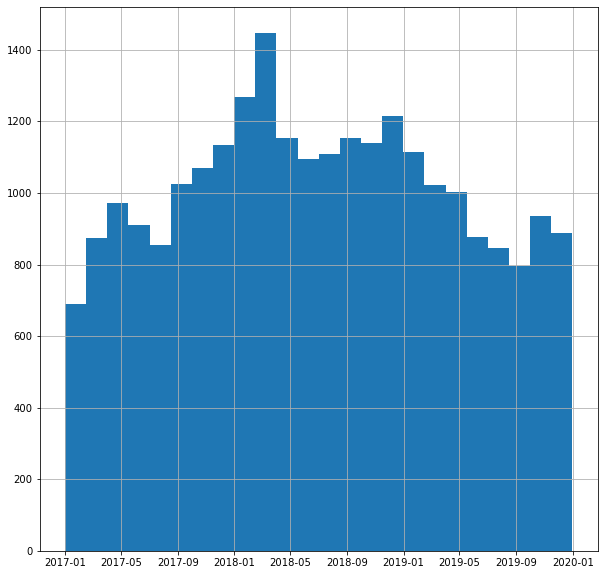

In [77]:
pd.to_datetime(sos_dors["DODSDAT"], errors="coerce", format="%Y%m%d").dropna().hist(bins=24, figsize=(10,10))

## Generate HTML

In [286]:
importlib.reload(skane1718)
import mim.extractors.skane_1718 as skane1718

dfs = {
    "liggaren": liggaren,
    "prelim": prelim,
    "labb": labb,
    "melior_kontakt": melior_diagnoser_vid_kontakt,
    "melior_post_30dagar": melior_diagnoser_30dagar_efter,
    "melior_pre_5yr": melior_diagnoser_5ar_fore,
    "sos_sluten": sos_sluten,
    "sos_dors": sos_dors
}
            
    
### XXX: Checkout 10001265 -- nothing in Melior???
    
#10237978
#10227673 -- duplicate blood samples ???
skane1718.write_patient_html(10163425, "foo.html", dfs)

<tr bgcolor="#77BB99"><td>SoS_SV</td><td>2013-03-22 00:00:00</td><td>2013-03-25 00:00:00<br/>Kvinna, 66 år</td><td>Huvuddiagnos: K573<br/>K573, G40, I252</td><td></td><td>Planerad Vård: 2<br/>Sjukhus: Centralsjukhuset i Kristianstad<br/>MVO: Kirurgisk vård</td></tr>
<tr bgcolor="#77BB99"><td>SoS_SV</td><td>2015-12-14 00:00:00</td><td>2015-12-16 00:00:00<br/>Kvinna, 69 år</td><td>Huvuddiagnos: nan<br/>G40, I252, I259, I109, E660</td><td></td><td>Planerad Vård: 2<br/>Sjukhus: Sjukhuset i Hässleholm<br/>MVO: Internmedicinsk vård </td></tr>
<tr bgcolor="#99CCCC"><td>Melior<br/>--Pre-5-years<br/></td><td>2015-12-15 09:00:00</td><td>2015-12-16 14:20:26</td><td colspan=3>2015-12-15 13:22:14: R074 (Huvuddiagnos)  (Bröstsmärtor, ospecificerade) (Slutenvård) (Inskrivning Läk)<br/>2015-12-17 13:49:18: E660 (Bidiagnos)  (Fetma orsakad av kaloriöverskott) (Slutenvård) (Epikris)<br/>2015-12-17 13:49:18: G409 (Bidiagnos)  (Epilepsi, ospecificerad) (Slutenvård) (Epikris)<br/>2015-12-17 13:49:18: I259 

In [ ]:
df = pd.read_csv(FILES["PATIENTLIGGAREN_Vårdkontakter_2017_2018_Triagekategorier.csv"], sep="|", encoding="ISO-8859-1")
display(list(df))
display(df.head())
display(len(df))

In [ ]:
len(set(df["KontaktId"]))

In [32]:
liggaren.dtypes

KontaktId                                  object
Alias                                       int64
AktuellSjukhusId                           object
Sjukhus_Namn                               object
BesokOrsakId                              float64
BesokOrsak_Kod                             object
BesokOrsak_Beskrivning                     object
Vardkontakt_InskrivningDatum               object
Vardkontakt_UtskrivningDatum               object
Vardkontakt_PatientAlderVidInskrivning      int64
Patient_Kon                                object
Utskriven till                             object
Inläggningsavdelning                       object
Vårddtid på akuten i minuter              float64
Tid till läkare på akuten i minuter       float64
Första läkarkontakten på akuten            object
Avvikit mot rekommendation                  int64
Inlagd                                      int64
Process_text                               object
UppföljningParameter_text                  object


## SVAR

In [ ]:
svar = pd.read_csv(FILES["SVAR_Hela_Skåne_17_18.csv"], sep="|", encoding="ISO-8859-1")
display(list(svar))
display(svar.head())
display(len(svar))

In [ ]:
pd.to_datetime(svar["AnkomsttillakutmottagningAkutvårdsregistrering"]).isna().sum()

In [ ]:
svar = svar.dropna(how="all")

In [ ]:
liggaren["Vardkontakt_InskrivningDatum"].sort_values()

In [ ]:
svar["AnkomsttillakutmottagningAkutvårdsregistrering"].sort_values()

In [ ]:
list(liggaren)

In [ ]:
AktuellSjukhudId_2_Sjukhus_Namn = {
    "SE162321000255-O11414": "SUS Malmö",
    "SE162321000255-O12014": "Helsingborgs lasarett",
    "O10001": "SUS Lund",
    "SE162321000255-O10532": "Centralsjukhuset Kristianstad",
    "SE162321000255-O16571": "Ystads lasarett",
    "SE162321000255-O11016": "Lasarettet Trelleborg",
    "O11249": "Hässleholms sjukhus",
    "O10971": "Lasarettet i Landskrona",
    "SE162321000255-O12784": np.nan,
    "SE162321000255-O22178YLOE": np.nan,
    "SE162321000255-O11962": "Ängelholms sjukhus",
    "SE162321000255-O18814KROE": np.nan,
    "O12984": "Barn- och ungdomsmedicinska kliniken Malmö",
    "O17830KR": "Psykiatri Skåne Kristianstad",
    "SE162321000255-O20919": "Kvälls- och Helgmottagningen Södervärn Malmö"
}

In [ ]:
liggaren[liggaren["AktuellSjukhusId"] == "SE162321000255-O18814KROE"]

In [ ]:
s = "SE162321000255-O20919"
x = liggaren[liggaren["AktuellSjukhusId"] == s]["Sjukhus_Namn"]
display(len(x))
display(x.isna().sum())
display(x.value_counts())

In [ ]:
liggaren["AktuellSjukhusId"].value_counts()

In [ ]:
x_key_cols=[
    "Vardkontakt_InskrivningDatum",
    "Vardkontakt_UtskrivningDatum",
    "Vardkontakt_PatientAlderVidInskrivning",
    "Patient_Kon",
    "Sjukhus_Namn",
    "AktuellSjukhusId",
    "Inlagd"
]
for c in x_key_cols:
    display(f"{c} -- {liggaren[c].isna().sum()}")

In [ ]:
l = liggaren["Vardkontakt_InskrivningDatum"].value_counts()
l[l<2]


In [ ]:
l = set(pd.to_datetime(liggaren.drop_duplicates("Vardkontakt_InskrivningDatum", keep=False)["Vardkontakt_InskrivningDatum"]).sort_values())

In [ ]:
s = set(pd.to_datetime(svar.drop_duplicates("AnkomsttillakutmottagningAkutvårdsregistrering", keep=False)["AnkomsttillakutmottagningAkutvårdsregistrering"]).sort_values())

In [ ]:
len(l.intersection(s))

In [ ]:
len(liggaren)

In [ ]:
svar.iloc[38429,:]

In [ ]:
svar.iloc[563484,:]

## Bodil och Anders

### Besoksorsaker

In [ ]:
liggaren["BesokOrsak_Beskrivning"].value_counts()

In [ ]:
liggaren["BesokOrsak_Kod"].value_counts()

In [ ]:
len(liggaren)

In [ ]:
counts = (liggaren["BesokOrsak_Kod"].fillna("--SAKNAS--") + "~" + liggaren["BesokOrsak_Beskrivning"].fillna("--SAKNAS--")).value_counts()
for k in sorted(counts.keys()):
    print(f"{k}~{counts[k]}")

### Make df

In [ ]:
orsaker = ["Buksmärta RETTS-A 6, RETTS-P 106", "Smärta i extremitet RETTS-A 15, RETTS-P115"]
abexpain_liggare = liggaren[((liggaren["BesokOrsak_Beskrivning"] == orsaker[0]) | (liggaren["BesokOrsak_Beskrivning"] == orsaker[1]))]

In [ ]:
## I checked, for the 2 Socialstyrelsen Lopnr that map to two different Aliases, only one alias occurs in this subset, so we can safely make a join on Socialstyrelsens key here:
abexpain_liggare = abexpain_liggare.set_index("Alias").join(sos_nyckel.set_index("Alias"))

In [ ]:
abexpain_liggare["Vardkontakt_InskrivningDatum"] = pd.to_datetime(abexpain_liggare["Vardkontakt_InskrivningDatum"])
abexpain_liggare["LopNr"] = abexpain_liggare["LopNr"].fillna("-1").astype(int)

In [ ]:
abexpain_liggare.dtypes

### First glance

In [ ]:
abexpain_liggare.head(4).T

In [ ]:
## Initial info

print("=========")
display(f"Total number of visits: {len(abexpain_liggare)}. Män: {(abexpain_liggare['Patient_Kon'] =='M').sum()}, Kvinnor: {(abexpain_liggare['Patient_Kon'] =='F').sum()}")
print("=========")
display("By patient")
display(abexpain_liggare.index.value_counts())
print("=========")
display(f"Inlagd: {abexpain_liggare['Inlagd'].sum()}. Män: {((abexpain_liggare['Patient_Kon'] =='M') & (abexpain_liggare['Inlagd'] == 1)).sum()}, Kvinnor: {((abexpain_liggare['Patient_Kon'] =='F') & (abexpain_liggare['Inlagd'] == 1)).sum()}")
print("=========")
display("Utskriven till")
display(abexpain_liggare["Utskriven till"].value_counts())
print("=========")
display("Sjukhus fördelning")
display(abexpain_liggare["Sjukhus_Namn"].fillna("??? Saknas ???").value_counts())
print("=========")

In [ ]:
## Eventuellt återanvända personnummer

abexpain_liggare["AterPNr"].sum()

In [ ]:
## Distribution över tid

pd.to_datetime(abexpain_liggare["Vardkontakt_InskrivningDatum"]).hist(bins=24, figsize=(10,10))

In [ ]:
abexpain_liggare["Vardkontakt_PatientAlderVidInskrivning"].hist(bins=20, figsize=(10,10))

In [ ]:
abexpain_liggare[abexpain_liggare["Utskriven till"] == "Avdelning"]["Inläggningsavdelning"].value_counts()

### Diagnoser

In [ ]:
#Arterial thrombosis in the abdominal or lower extremity circulation: I74.0, I74.1, I 74.2, I 74.3, I74.4, I74.5, I74.8, I74.9, K55.0, K55.1, K55.9, N28.0.
#Venous thrombosis in the abdominal or lower extremity circulation: I80.1, I80.2, I80.3, I80.8, I80.9, I81.9.
icd = set(sos_sluten["hdia"])


In [ ]:
art_thromb_icd = ["I740", "I741", "I742", "I743", "I744", "I745", "I748", "I749", "K550", "K559", "N280", "N28"]
ven_thromb_icd = ["I801", "I802", "I803", "I808", "I809", "I819"]
for i in ven_thromb_icd:
    print(f"{i}\t{i in icd}")

#### Allmän överblick över huvuddiagnoser i slutenvårdsregistret från SoS.

In [ ]:
#for k,v in sos_sluten["hdia"].value_counts().items():
#    print(f'{k}\t{v}')
c = sos_sluten["hdia"].value_counts()
print("Förekomst av diagnoser i hela slutenvårdsregistret (även andra sökorsaker)")
display(c)


## N28* har trunkerats till N28.

for s, l in zip(["Arterial thrombosis", "Venuous thrombosis"], [art_thromb_icd, ven_thromb_icd]):
    print(s)
    for i in l:
        if i in c:
            print(f"{i}\t{c[i]}")
        else:
            print(f"{i} -- missing")
    print()

#### Tromboser i Slutenvården

In [ ]:
skipped = 0
acount = 0
vcount = 0
ecount = 0
for alias, r in abexpain_liggare.iterrows():
    lopnr = r["LopNr"]
    if lopnr == -1:
        skipped += 1
        continue
#    print(lopnr)
    v, a = False, False
    for hdia in sos_sluten[(sos_sluten["LopNr"] == lopnr) & (r["Vardkontakt_InskrivningDatum"] <= sos_sluten["INDATUM"]) & (sos_sluten["INDATUM"] <= (r["Vardkontakt_InskrivningDatum"] + pd.Timedelta("90D")))]["hdia"]:
        a = a or hdia in art_thromb_icd
        v = v or hdia in ven_thromb_icd
    if a:
        acount += 1
    if v:
        vcount += 1
    if a or v:
        ecount += 1

print(f"Skipped: {skipped}")
print(f"Arterial: {acount}")
print(f"Venuous: {vcount}")
print(f"Either: {ecount}")
print(f"Total: {len(abexpain_liggare)}")

In [ ]:
abexpain_liggare.dtypes

## Exempel

In [ ]:
sos_nyckel[sos_nyckel["Alias"] == 10261943]

In [ ]:
liggaren[liggaren["Alias"] == 10261943].T

In [ ]:
melior_diagnoser_vid_kontakt[melior_diagnoser_vid_kontakt["Alias"] == 10261943].T

In [ ]:
sos_sluten[sos_sluten["LopNr"] == 134374]

In [ ]:
abexpain_liggare.head(10)

In [ ]:
abexpain_liggare.loc[10000021]

In [ ]:
melior_diagnoser_vid_kontakt[melior_diagnoser_vid_kontakt["Alias"] == 10000021].T

In [ ]:
sos_nyckel[sos_nyckel["Alias"] == 10000021]

In [ ]:
for l in list(sos_sluten):
    print(l)

In [ ]:
sluten_cols=["EKOD1", "SJUKHUS", "MVO", "INDATUM", "UTDATUM", "hdia", "OP", "DIA_ANT", "DIA1", "DIA2", "DIA3", "DIA4"]

sos_sluten[sos_sluten["LopNr"] == 102295][sluten_cols].sort_values("INDATUM")

## Mismatch SoS -- Skåne17-18

In [ ]:
abexpain_liggare[abexpain_liggare['LopNr'].isna()]["Utskriven till"].value_counts()

## SECTRA

In [ ]:
sectra_a = pd.read_csv(FILES["SECTRA_export2012_2015A.csv"], sep="|", encoding="ISO-8859-1")
sectra_b = pd.read_csv(FILES["SECTRA_export2016_2018A.csv"], sep="|", encoding="ISO-8859-1")
sectra = pd.concat([sectra_a, sectra_b])

In [ ]:
sectra_a.dtypes

In [ ]:
sectra_a.sort_values("Undersökningsdatum")

In [ ]:
sectra_b.sort_values("Undersökningsdatum")

In [ ]:
## From 
## https://vardgivare.skane.se/siteassets/1.-vardriktlinjer/med-omraden/bild-funktion/undersokningsmetoder-bof-rontgen32.pdf
## and
## https://vardgivare.skane.se/siteassets/2.-patientadministration/avgifter-och-prislistor/prislistor/bfm/Prislista-bild-och-funktion.xlsx

sectra_koder = {
#     10000: "Neuroradiologisk us utan egen kod",
#     13000: "Lumbalpunktion",
#     13017: "Lumbalpunktion och tryckmätning",
#     13050: "Lumbalpunktion för odling/cellanalys",
#     13100: "Lumbothorakal myelografi",
#     13400: "Myelografi för efterföljande datortomografi",
#     13700: "Lumbal vertebroplastik",
#     17000: "Carotis communis-angiografi",
#     17048: "Carotis communis-angiografi med inläggning av stent",
#     17062: "Carotis communis-angiografi med stentgraft",
#     17130: "Carotis interna-angiografi med tomografi och/eller 3D",
#     17148: "Carotis interna-angiografi med inläggning av stent",
#     17162: "Carotis interna-angiografi med stentgraft",
#     17500: "Kombination av två eller flera skallangiografi",
#     17530: "Kombination av två eller flera skallangiografi med tomografi och/eller 3D",
#     17575: "Skallangiografi med intravenös tomografi",
#     17800: "Spinal angiografi",
    "22200": "Arbetsprov",
    "22203": "Arbetsprov armcykling",
    "22204": "Arbetsprov på rullande matta",
    "22205": "Arbetsprov med pulsoximetri",
    "22206": "Arbetsprov med PEF",
    "22208": "Arbetsprov med pulsoximetri och PEF",
    
    "23210": "Arbetsprov med blodgaser",
    
    "32000": "Lungor",
    "32028": "Lungor endast genomlysning",
    "32030": "Lungor tomosyntes",
    "32300": "Lungor undersökning i liggande",
    "32320": "Lungor, liggande barn (frontal- och sidobild)",
    "37300": "Coronarangiografi ett eller flera kärl",
    "39600": "Coronarangiografi med PCI utan stent",
    "39648": "Coronarangiografi med PCI med stent",
  
    "72110": "Scintigrafi myokard vila och belastning",
    "72120": "Scintigrafi myokard vila och arbete",
    
    "73110": "Scintigrafi lungor",
    "73130": "Scintigrafi lungor ventilation perfusion med fördelning",
    "73400": "Scintigrafi tomografi lungor",
    "73403": "Scintigrafi tomografi inklusive DT lungor",

    "83000": "DT thorax utan iv kontrast",
    "83007": "DT thorax översiktsundersökning",
    "83050": "DT thorax med punktion/biopsi",
    "83051": "DT thorax med punktion och kateterinläggning",
    "83076": "DT thorax högupplösande (HRCT)",
    "83077": "DT thorax med låg stråldos",
    "83080": "DT thorax med iv kontrast",
    "83081": "DT thorax utan och med iv kontrast",
    
    "83100": "DT hjärta",
    "83180": "DT hjärta med iv kontrast",
    "83600": "DT thorax och övre buk utan iv kontrast",
    "83680": "DT thorax och övre buk med iv kontrast",
    "83681": "DT thorax och övre buk utan och med iv kontrast",
    "83900": "DT thorax och buk utan iv kontrast",
    "83980": "DT thorax och buk med iv kontrast",
    "83981": "DT thorax och buk utan och med iv kontrast",
    
    "84000": "DT buk utan iv kontrast",
    "84050": "DT buk med punktion",
    "84051": "DT buk med dräninläggning",
    "84080": "DT buk med iv kontrast",
    "84081": "DT buk utan och med iv kontrast",

    "92000": "Ekokardiografi",
    "92007": "Ekokardiografi riktad undersökning",
    "92072": "Ekokardiografi 3D",
    "92200": "Ekokardiografi transesofagalt",
    
    "94000": "ULJ buk",
    "94050": "ULJ buk med punktion/biopsi",
    "94051": "ULJ buk med kateterinläggning",
    "94081": "ULJ buk utan och med iv kontrast",
    
    "M3100": "MRT hjärta",
    "M3107": "MRT hjärta kort undersökning",
    "M3127": "MRT hjärta funktionsstudie",
    "M3181": "MRT hjärta utan och med iv kontrast"
}

In [ ]:
for k in sorted(sectra_b["Undersökningskod"].value_counts().keys()):
    #if k not in sectra_koder.keys():
        print(k)

In [ ]:
counts = sectra["Undersökningskod"].value_counts()
counts_recent = sectra[pd.to_datetime(sectra["Undersökningsdatum"]) >= pd.to_datetime("2017-01-01")]["Undersökningskod"].value_counts()
for k in sorted(counts.keys()):
    n_recent = counts_recent[k] if k in counts_recent else 0
    print(f'{k}~{sectra_koder[k]}~{counts[k]}~{n_recent}')

In [ ]:
sectra["Undersökningsdatum"].sort_values()

In [ ]:
sectra["Fullständigt svar"].value_counts().head(10)

In [ ]:
sectra.dtypes

## Åtgärder

In [ ]:
atgarder_30_dagar = pd.read_csv(FILES["MELIOR_Åtgärder30DagarEfterVårdkontakt_2017_2018.csv"], sep="|", encoding="ISO-8859-1")
atgarder_vid_kontakt = pd.read_csv(FILES["MELIOR_ÅtgärderVidVårdkontakt_2017_2018.csv"], sep="|", encoding="ISO-8859-1")
atgarder_till_2020 = pd.read_csv(FILES["MELIOR_PatientAtgarder_Efter_Vardkontakt_UtskrivningDatum_Till_20191231.csv"], sep="|", encoding="ISO-8859-1")


In [ ]:
a = list(atgarder_30_dagar)
b = list(atgarder_vid_kontakt)
c = list(atgarder_till_2020)
a

In [ ]:
b

In [ ]:
c

In [ ]:
x = atgarder_30_dagar["PatientAtgard_Kod"].value_counts()

In [ ]:
atgarder_30_dagar.head()

## Axel Check

In [149]:
pat_165 = pd.read_csv("/home/sapfo/andersb/165_pat.txt",sep="\t")
pat_165

,pseudo,index,Vardkontakt_InskrivningDatum,Alias_sk1718,icd10,diagnosis_date
0,2017-02-04 07:17:00 -- 2017-02-04 15:04:00,{8E5DCE0C-2CC1-46FE-B368-CCEDB080DE86},2017-02-04 07:17:00,10043140,I214,2017-02-17 14:12:46
1,2017-02-05 16:52:00 -- 2017-02-05 20:08:00,{18E1F40C-080D-46F4-85C1-2B61FDCA1986},2017-02-05 16:52:00,10257242,I219,2017-02-05 19:48:13
2,2017-02-06 05:31:00 -- 2017-02-06 13:46:00,{050AF275-D8F5-47B9-930E-B7E7A53A35E6},2017-02-06 05:31:00,10087186,I219,2017-02-16 10:53:59
3,2017-02-07 22:05:00 -- 2017-02-08 02:34:00,{F8E7F88C-F544-4C8E-A57D-7AD9B4838BC1},2017-02-07 22:05:00,10148763,I219,2017-02-08 04:32:43
4,2017-02-10 21:22:00 -- 2017-02-11 00:19:00,{C86250B4-FB52-4627-AFDD-2EF4E6F3FCF8},2017-02-10 21:22:00,10124919,I214,2017-02-11 01:46:18
...,...,...,...,...,...,...
188,2018-11-18 10:19:00 -- 2018-11-18 21:52:00,{7057923E-C853-429F-B360-4CD003AD5418},2018-11-18 10:19:00,10135181,I214X,2018-12-07 15:58:35
189,2018-11-19 15:38:00 -- 2018-11-19 20:34:00,{F0A6CD93-B6BB-4D2C-B613-E50E70F2CEEB},2018-11-19 15:38:00,10175885,I214,2018-11-19 18:26:09
190,2018-11-22 09:15:00 -- 2018-11-22 20:30:00,{5921F2C7-C329-4134-A91C-60822A016394},2018-11-22 09:15:00,10032500,I219,2018-11-26 14:31:04
191,2018-11-23 11:50:00 -- 2018-11-23 15:40:00,{CE40F1D2-9005-40AB-879C-7FA95F6B5121},2018-11-23 11:50:00,10300234,I214,2018-11-23 15:35:47


In [34]:
i200_pats = pd.read_csv("/home/sapfo/andersb/i200_only_melior.csv")
i200_pats

,pseudo,diagnosis_date,Alias_esctrop,Alias_sk1718
0,2017-02-01 11:35:00 -- 2017-02-01 16:29:00,2017-02-01 16:16:33,{53E5D93A-5EDF-4A87-B409-AC076EA097EB},10092598
1,2017-02-01 12:40:00 -- 2017-02-01 15:44:00,2017-02-01 17:33:12,{13C98937-E304-4BD6-940D-4A6D7C5B0485},10145842
2,2017-02-01 20:16:00 -- 2017-02-02 01:43:00,2017-02-21 19:52:55,{4AE53E62-0D1C-4D53-A226-5B339780A44A},10014230
3,2017-02-02 18:01:00 -- 2017-02-02 22:12:00,2017-02-02 21:13:20,{F914FBAF-DDC4-451E-B4D2-25F1BFD319A4},10140731
4,2017-02-06 10:35:00 -- 2017-02-06 18:39:00,2017-02-06 16:51:33,{7CCFA2D4-31FB-488D-8935-D6F086B7DA99},10243823
...,...,...,...,...
184,2018-11-06 10:37:00 -- 2018-11-06 20:56:00,2018-11-06 16:21:21,{D4211629-9805-486A-91FE-688C0FADFD86},10209786
185,2018-11-15 09:28:00 -- 2018-11-15 18:15:00,2018-11-15 18:37:18,{60E16F21-412C-4CEC-B149-8353D9E4B83D},10086056
186,2018-11-23 20:07:00 -- 2018-11-24 05:50:00,2018-11-24 05:38:47,{395AC580-3652-4EE9-BAA5-1304C08A5217},10109859
187,2018-11-26 17:57:00 -- 2018-11-26 19:26:00,2018-11-27 05:30:07,{09679003-BEDC-4560-A2F2-185AC54738FF},10088448


In [54]:
distant_future = datetime(year=2025,month=12,day=31)

diag_prefix="I200"  # "I21"
df = i200_pats # "pat_165"


def lookup(alias, diag_date):
    a = dfs["melior_pre_5yr"][dfs["melior_pre_5yr"]["Alias"] == alias].drop(["TermId", "KontaktId"], axis=1).fillna({"VårdtillfälleFörDiagnos_SlutDatum": "n/a"})
    b = dfs["melior_kontakt"][dfs["melior_kontakt"]["Alias"] == alias].drop("KontaktId", axis=1).fillna({"VårdtillfälleFörDiagnos_SlutDatum": "n/a"})
    c = dfs["melior_post_30dagar"][dfs["melior_post_30dagar"]["Alias"] == alias].drop(["TermId", "KontaktId"], axis=1).fillna({"VårdtillfälleFörDiagnos_SlutDatum": "n/a"})

    for df in [a, b, c]:
        df["VårdtillfälleFörDiagnos_SlutDatum"] = df["VårdtillfälleFörDiagnos_SlutDatum"].replace("n/a", str(distant_future))
        df['vtkey'] = df["VårdtillfälleFörDiagnos_StartDatum"] + "~" + df["VårdtillfälleFörDiagnos_SlutDatum"]

    vtkeys = set(pd.concat([a['vtkey'], b['vtkey'], c['vtkey']]))
    m_table = {}

    for vtkey in vtkeys:
        v = ""
        if (a['vtkey'] == vtkey).sum() > 0:
            v += "Pre-5-years<br/>"
        if (b['vtkey'] == vtkey).sum() > 0:
            v += "Contact<br/>"
        if (c['vtkey'] == vtkey).sum() > 0:
            v += "Post 30d<br/>"
        m_table[vtkey] = v

    cat = pd.concat([a,b,c]).drop_duplicates()
    
    r = cat[(cat["Alias"] == alias) & (cat["PatientDiagnos_ModifieradDatum"] == diag_date)]
    #x = r["VårdtillfälleFörDiagnos_SlutDatum"].replace("n/a", str(distant_future), inplace=True)
    #r.loc[] = x
    return r


pats = defaultdict(list)
counts = []
counters = Counter()
for k, row in df.iterrows():
    alias = row["Alias_sk1718"]
    print(alias)
    diag_date = row["diagnosis_date"]
    r = lookup(alias, diag_date)
    diag_date = parse_iso8601_datetime(diag_date)
    c = 0
    index_date = parse_iso8601_datetime(row["pseudo"].split(" -- ")[0])
    for k, r2 in r.iterrows():
        diag = r2["PatientDiagnos_Kod"]
        if not diag.startswith(diag_prefix):
            continue
        c += 1
        vardform = r2["VårdtillfälleFörDiagnos_VardformText"]
        vt_start = parse_iso8601_datetime(r2["VårdtillfälleFörDiagnos_StartDatum"])
        vt_end = parse_iso8601_datetime(r2["VårdtillfälleFörDiagnos_SlutDatum"])
        print(f'{r2["PatientDiagnos_ModifieradDatum"]}\t{diag}\t{r2["Diagnostyp"]}\t{r2["AktivitetTyp"]}\t{vardform}')
        index_start_diff = vt_start - diag_date
        k = "O" if vardform == "Öppenvård" else "S"
        k += "_ErrEnd" if vt_end < index_date else "_OkEnd"
        #k += "_ErrStart" if index_start_diff > timedelta(days=30) else "_OkStart"
        k2 = k+"_"+r2["AktivitetTyp"]
        counters[k] += 1
        counters[k2] += 1
        pats[k2].append(alias)

    print()
    counts.append(c)
    
print(counts)
for k in sorted(counters.keys()):
    print(f'{k}\t{counters[k]}')
#print(f"Oppen: {oppen}")
#print(f'Sluten: {sluten}')
for p in pats["S_OkEnd_Akutkliniken Läk"]:
    print(p)

    

10092598
2017-02-01 16:16:33	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10145842
2017-02-01 17:33:12	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

10014230
2017-02-21 19:52:55	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10140731
2017-02-02 21:13:20	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

10243823
2017-02-06 16:51:33	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10026158
2017-02-07 18:50:43	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

10070615
2017-02-15 15:50:23	I200	Huvuddiagnos	Akutmottagning Läk	Slutenvård

10005495
2017-02-13 14:07:51	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

10047236
2017-02-16 15:59:19	I200	Huvuddiagnos	Konsultanteckning/Remissvar	Slutenvård

10249023
2017-02-17 07:54:03	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10207813
2017-02-20 18:36:25	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10149536
2017-02-20 14:43:50	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

10275222
2017-02-23 20:42:46	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

1020

2018-03-20 15:42:38	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10284439
2018-03-21 14:50:19	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

10311830
2018-03-22 19:33:25	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

10142433
2018-03-26 16:32:08	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10007323
2018-03-28 21:41:28	I200	Huvuddiagnos	Anteckning ÖV Läk	Slutenvård

10225705
2018-03-29 20:03:29	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

10223505
2018-03-31 20:15:08	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

10223505
2018-03-31 20:33:16	I200	Huvuddiagnos	Konsultanteckning/Remissvar	Slutenvård

10254513
2018-04-01 04:14:44	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10001665
2018-04-04 14:41:28	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10099744
2018-04-06 13:55:27	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10275942
2018-04-06 12:35:07	I200	Huvuddiagnos	Inskrivning Läk	Slutenvård

10088171
2018-04-09 02:54:33	I200	Huvuddiagnos	Akutkliniken Läk	Slutenvård

10201082
2018-0

## DF check

In [175]:
def list_cols(df):
    cols = list(df)
    for c in cols:
        nz = len(df) - df[c].isna().sum()
        unique_values = len(df[c].value_counts())
        print(f'{c}\t{df.dtypes[c]}\t--label\t{nz}\t{unique_values}')

list_cols(sos_dors)

LopNr	int64	--label	25273	25273
AR	int64	--label	25273	3
DODSDAT	int64	--label	25273	1134
KON	int64	--label	25273	2
alder	int64	--label	25273	89
LK	float64	--label	25257	169
ICD	int64	--label	25273	1
LKF	float64	--label	0	0
ULORSAK	object	--label	25273	1031
KAP19	object	--label	1320	141
MORSAK1	object	--label	25273	740
MORSAK2	object	--label	20306	1074
MORSAK3	object	--label	15464	1082
MORSAK4	object	--label	10843	934
MORSAK5	object	--label	7009	804
MORSAK6	object	--label	4223	624
MORSAK7	object	--label	2435	467
MORSAK8	object	--label	1369	355
MORSAK9	object	--label	757	278
MORSAK10	object	--label	381	172
MORSAK11	object	--label	207	123
MORSAK12	object	--label	107	80
MORSAK13	object	--label	54	51
MORSAK14	object	--label	32	30
MORSAK15	object	--label	16	16
MORSAK16	object	--label	12	12
MORSAK17	object	--label	7	7
MORSAK18	object	--label	4	4
MORSAK19	object	--label	2	2
MORSAK20	object	--label	2	2
MORSAK21	object	--label	1	1
MORSAK22	object	--label	1	1
MORSAK23	float64	--label	0	0
MORSAK2

In [199]:
sos_dors["LK"].value_counts()

1280.0    5429
1283.0    2824
1290.0    1800
1281.0    1675
1293.0    1229
          ... 
1481.0       1
1860.0       1
687.0        1
1460.0       1
188.0        1
Name: LK, Length: 169, dtype: int64

## BOTTOM